<a href="https://colab.research.google.com/github/gheorghebg11/Shell/blob/master/Shell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the files into Colab

The first cells are for loading the big data files from google drive (as colab only keeps the files for 12 hours), and the .csv from my local drive or dropbox. We first authenticate and connect to google drive.

In [1]:
!pip install PyDrive
!pip install -U tensorboardcolab
import os, zipfile
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials

auth.authenticate_user()

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)


Now download the files and un unzip the archives. Right now there are 4 folders for 4 different gas station brands.

In [0]:
!mkdir /content/data
print('\nDownloading the data')
download = drive.CreateFile({'id': '1e5u2uDQ5mupV64KJbmWVG-JhlGKz9uUD'})
download.GetContentFile('/content/data_shell.tar.gz')
!tar -xzf /content/data_shell.tar.gz -C /content/data
print('\nData successfully downloaded in /content/data')
!rm /content/data_shell.tar.gz
!rm -r /content/sample_data



Data successfully downloaded in /content/data


# Data Visualization and Basic Cleaning

First load some packages for Data Visualization.

In [0]:
import numpy as np
np.random.seed(1989)

import cv2
from albumentations import Compose
import albumentations.augmentations.transforms as alb

import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_columns = 20

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

First setup the working directory and get a list of the labels. There is one folder per label, containing all the images associated with that label.

We will now loop through all files and do a few tasks:
- check for corrupted files (ending in .part)
- check for all available extensions, in order to exlcude non-images
- rename each file in the formal 'label_oldfilename' and move them all in one single folder.

In [3]:
dir_data = '/content/data/'
labels = list(os.listdir(dir_data))

extensions = set()

for label in labels:
    dir_label = os.path.join(dir_data, label)
    filenames = [name for name in os.listdir(dir_label) if os.path.isfile(os.path.join(dir_label, name))]
    
    for filename in filenames:
        new_filename = label + '_' + filename
        os.rename(os.path.join(dir_label, filename), os.path.join(dir_data,new_filename))
        
        # check for the extension
        extension = filename.split('.')[-1]
        if extension not in extensions:
            extensions.add(extension)
    
    # erase the empty folder
    os.rmdir(os.path.join(dir_data, label))
    #shutil.rmtree(os.path.join(dir_data, label))
    
print(f'We found the extensions {extensions}')

# create a list with all filenames MAYBE PUT IN PANDAS ?
filenames = [name for name in os.listdir(dir_data) if os.path.isfile(os.path.join(dir_data, name))]

We found the extensions {'jpg', 'jpeg', 'png', 'part'}


We will now erase the files ending in .part as they are corrupted images that failed during data mining. We also create a list with all the images path and their size in order to explore that data.

In [4]:
corrupted_files = 0
filenames_and_labels = []

for filename in filenames:
    if filename.endswith('.part'):
        corrupted_files = corrupted_files + 1
        os.remove(os.path.join(dir_data, filename))
        #filenames.remove(filename)
    else:
        dims = cv2.imread(os.path.join(dir_data, filename)).shape
        filenames_and_labels.append((filename, filename.split('_')[0], dims[1], dims[0], dims[2], dims[0]*dims[1]))
        
print(f'We removed {corrupted_files} corrupted files out of {len(filenames) + corrupted_files} total files.')

We removed 7 corrupted files out of 783 total files.


We now create a Pandas df with the data and explore it a little bit.

In [5]:
train = pd.DataFrame(filenames_and_labels, columns=['fname', 'label', 'xres', 'yres', 'channels', 'xyres'])
print(f'Train set has {train.shape[0]} examples and {len(set(train.label))} different labels. Here is a sample:')
train.sample(5)

Train set has 769 examples and 4 different labels. Here is a sample:


,fname,label,xres,yres,channels,xyres
244,chevron_162.jpg,chevron,1920,795,3,1526400
446,conoco_10.jpg,conoco,1300,954,3,1240200
89,phillips_112.jpg,phillips,500,375,3,187500
102,conoco_5.jpg,conoco,1600,581,3,929600
445,shell_191.jpg,shell,250,250,3,62500


Let's visualize how many samples there are per label.

The number of images per label ranges from 137 to 223


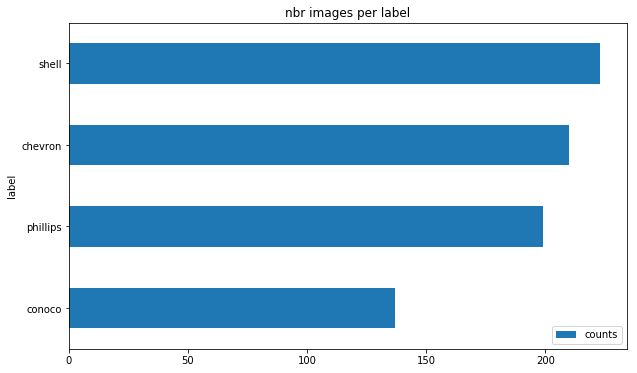

In [6]:
category_group = train[['fname', 'label']].groupby(['label']).count()
category_group.columns = ['counts']
print(f'The number of images per label ranges from {category_group.counts.min()} to {category_group.counts.max()}')
plot = category_group.sort_values(ascending=True, by='counts').plot(kind='barh', title='nbr images per label', figsize=(10,6))
plt.show()

We look at the smallest and largest dimensions, and check that all photos have 3 channels.



The smallest x-resolution is 
fname       chevron_213.jpg
label               chevron
xres                    150
yres                    150
channels                  3
xyres                 22500
Name: 282, dtype: object

The smallest y-resolution is 
fname       conoco_378.jpeg
label                conoco
xres                    299
yres                    133
channels                  3
xyres                 39767
Name: 75, dtype: object

The distribution of channels is given by:


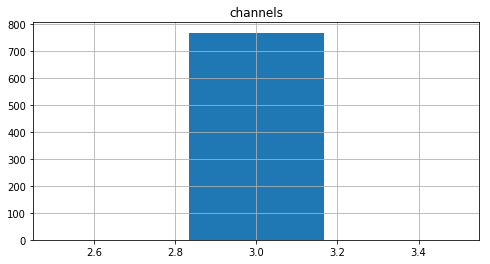

In [7]:
print(f'The smallest x-resolution is \n{train.iloc[train.xres.idxmin()]}\n')
print(f'The smallest y-resolution is \n{train.iloc[train.yres.idxmin()]}\n')

print('The distribution of channels is given by:')
train.hist(column='channels', bins=3, figsize=(8,4))
plt.show()

Let's now visualize the distribution of their dimensions:

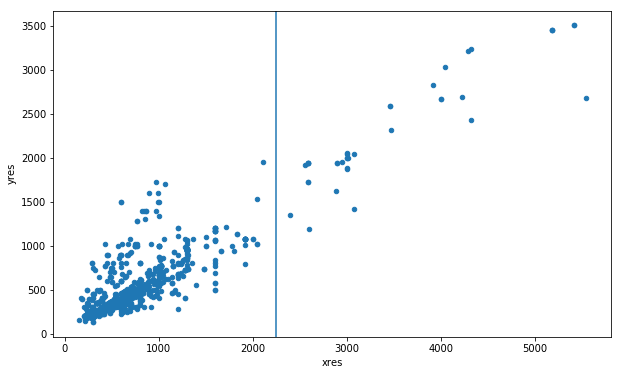

In [8]:
train.plot.scatter('xres', 'yres', figsize=(10,6))
plt.axvline(x=2250)
plt.show()

We see that the scales are not the same and that most photos have a larger x-resolution. We will remove some outliers to avoid huge resolutions. Let's put the threshold at x-res < 2250.

In [9]:
nbr_im_large_xres = train[train.xres > 2250].shape[0]
total_im = train.shape[0]
train = train.query('xres < 2250')

print(f'There are {nbr_im_large_xres} images (out of {total_im}) with x-resolution larger than 2250. We remove them and we are left with {train.shape[0]} images.')

There are 39 images (out of 769) with x-resolution larger than 2250. We remove them and we are left with 730 images.


Here is the new distribution of dimensions.

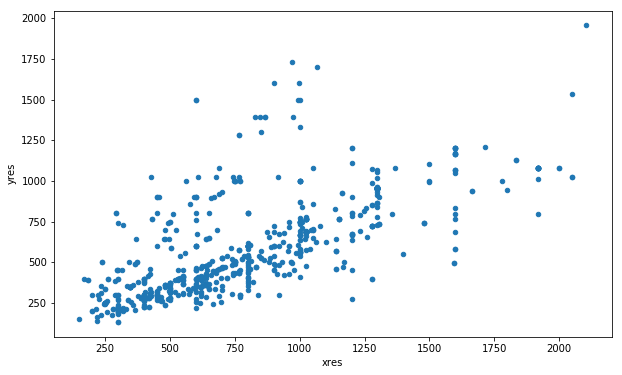

In [10]:
train.plot.scatter('xres', 'yres', figsize=(10,6))
plt.show()

Let's look at some samples, and look at what our data augmentation filters does.

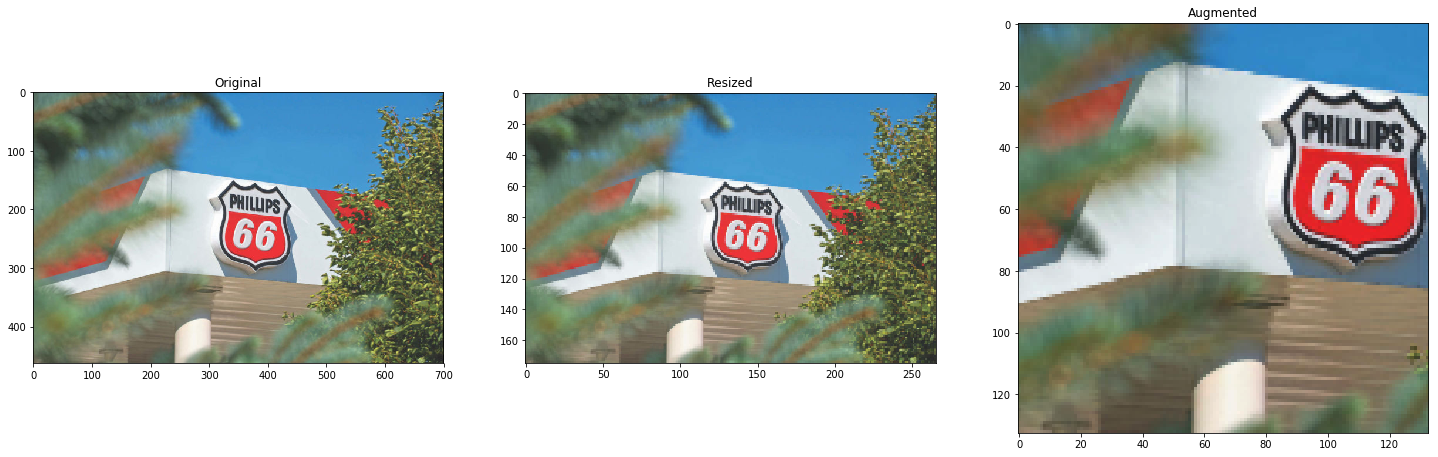

In [36]:
min_height_width = min(train['yres'].min(), train['xres'].min())

augmentation = Compose([ 
    alb.RandomCrop(min_height_width,min_height_width, p=1.0),
    #alb.Blur(blur_limit=2),
    alb.RandomGamma(p=1.0),
    alb.Rotate(15),
    alb.RandomBrightnessContrast(),
    alb.GaussNoise(),
    alb.ToFloat(max_value=255)
])

filename = train.sample(1).fname.values[0]
file_path = os.path.join(dir_data, filename)
img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_RGB2BGR) # convert in normal colors

_, ax = plt.subplots(1,3, figsize=(25,10))
ax[0].imshow(img)
ax[0].set_title('Original')

ratio_img_to_crop = max(img.shape[0]/min_height_width, img.shape[1]/min_height_width)
if ratio_img_to_crop > 2:
    img = cv2.resize(img,(int(img.shape[1] * 2 / ratio_img_to_crop), int(img.shape[0] * 2 / ratio_img_to_crop)))
    img = alb.PadIfNeeded(min_height=min_height_width, min_width=min_height_width)(image=img)["image"] ## IF PROBLEM USE MIN for crop and remove this.
    ax[1].imshow(img)
    ax[1].set_title('Resized')

img_aug = augmentation(image=img)["image"]
ax[2].imshow(img_aug)
ax[2].set_title('Augmented')
plt.show()

Finally we now save this cleaned dataframe.

In [0]:
train.to_csv(os.path.join(os.path.normpath(dir_data + os.sep + os.pardir), 'train.csv'), index=False)

# Construct The Model

First (Re)Load some Packages

In [37]:
import numpy as np
np.random.seed(1989)

import shutil, cv2
import pandas as pd

from albumentations import Compose
import albumentations.augmentations.transforms as alb

from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.layers import (Dense, Dropout, Input, Convolution2D, MaxPool2D, BatchNormalization, Flatten, Activation) 
from keras.utils import Sequence, to_categorical
from keras import backend as K

from sklearn.model_selection import StratifiedKFold
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

Using TensorFlow backend.


If you skipped the visualization section, download the dataframe and load it here.

In [0]:
download = drive.CreateFile({'id': '1ffAPRILKnRgHgmVQ_fcVtYlsMk8-sPsT'})
download.GetContentFile('/content/train.csv')
train = pd.read_csv('/content/train.csv')


Set up 
- some paths
- the dictionnary transforming the label names in numbers (needed by tf)
- the min x-res and y-res values (we have to ensure that we will crop the image to bigger values)
- the filename as index for the training dataframe.

In [38]:
dir_data = '/content/data'

labels = train['label'].unique()
labels_to_idx = {label: i for i, label in enumerate(labels)}
print(f'Here is the dictionnary for the labels: {labels_to_idx}')

n_classes = len(labels)

min_height = train['yres'].min()
min_width = train['xres'].min()
min_height_width = min(min_height, min_width)

print(f'The min height and width are {min_height} and {min_width}. These min values will be necessary for cropping the images.')

train.set_index('fname', inplace=True, drop=True)
train['label_idx'] = train.label.apply(lambda x: labels_to_idx[x])
train.head()

Here is the dictionnary for the labels: {'conoco': 0, 'shell': 1, 'chevron': 2, 'phillips': 3}
The min height and width are 133 and 150. These min values will be necessary for cropping the images.


,label,xres,yres,channels,xyres,label_idx
fname,,,,,,
conoco_343.jpg,conoco,404,320,3,129280,0
shell_184.jpg,shell,676,338,3,228488,1
chevron_352.jpg,chevron,600,600,3,360000,2
phillips_173.jpg,phillips,348,348,3,121104,3
phillips_230.jpg,phillips,1165,925,3,1077625,3


The Configuration class : In particular contains the default settings.

In [0]:
class Config(object):
	def __init__(self, model_name = 'dummy', n_classes=n_classes, image_size=(64,64,3), n_folds=1, n_preds = 1, learning_rate=0.0001, max_epochs=10):
		self.n_classes = n_classes
		self.image_size = image_size
		self.n_folds = n_folds
		self.n_preds = n_preds
		self.learning_rate = learning_rate
		self.max_epochs = max_epochs
		self.model_name = model_name

The Datagenerator class : Inherits from Keras.utils.Sequence to efficiently feed the data.

In [0]:
class DataGenerator(Sequence): # Inherits from Keras.utils.Sequence for multiprocessing

    def __init__(self, config, dir_data, list_IDs, labels=None,
					batch_size=16, shuffle=False, augmentation = None, preprocessing_fn=None):
    
        self.config = config
        self.dir_data = dir_data
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.preprocessing_fn = preprocessing_fn
        self.shuffle = shuffle
        
        # the following seems better than calling on_epoch_end, to avoid shuffle at beginning!
        self.indexes = np.arange(len(self.list_IDs))
        #self.on_epoch_end()
        

    # returns the number of batches in the Sequence (per 1 epoch)
    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    # returns the index^th complete batch
    def __getitem__(self,index):
        indexes_temp = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes_temp]
        return self.__data_generation(list_IDs_temp)

    # called at the end of an epoch: reloads IDs
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.config.image_size)) 
        
        for i,ID in enumerate(list_IDs_temp):
            file_path = os.path.join(self.dir_data, ID)
            
            # read the image
            img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_RGB2BGR) # convert in normal colors
            #plt.figure(), plt.imshow(img), plt.show()
            
            # other preprocesses (not augmenting though)
            if self.preprocessing_fn:
                img = self.preprocessing_fn(img) 
            
            # augment and save in the big array X
            if self.augmentation:
                ratio_img_to_crop = max(img.shape[0]/self.config.image_size[0], img.shape[1]/self.config.image_size[1]) ## Could also use max and pad around it
                if ratio_img_to_crop > 2:
                    img = cv2.resize(img,(int(img.shape[1] * 2 / ratio_img_to_crop), int(img.shape[0] * 2 / ratio_img_to_crop)))
                    img = alb.PadIfNeeded(min_height=min_height_width, min_width=min_height_width)(image=img)["image"] ## IF PROBLEM USE MIN for crop and remove this.
                    #plt.figure(), plt.imshow(img), plt.show()
                img = self.augmentation(image=img)["image"]
            
            # if it wasn't cropped or resized yet, we resize it so that it has the std size
            if img.shape != self.config.image_size:
                img = cv2.resize(img,(self.config.image_size[0],self.config.image_size[1]))

            #plt.figure(), plt.imshow(img), plt.show()
            
            X[i,] = img
            ### ADD HERE IMG VISUALIZATION or save in folder
        
        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            
            return X, to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X

Here is the dummy model with just a fully connected layer. Name = dummy

In [0]:
def get_dummy_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=config.image_size)
    out = Dense(nclass, activation=softmax)(inp)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

And the larger 2D conv model. Name = conv

In [0]:
def get_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=config.image_size)
    
    x = Convolution2D(256, (3,3), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(256, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(128, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(128, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

# Run The Model!

Set-up the Paths for the data

In [0]:
dir_log = os.path.join(os.path.normpath(dir_data + os.sep + os.pardir), 'logs')
if os.path.isdir(dir_log):
        shutil.rmtree(dir_log)

dir_pred = os.path.join(os.path.normpath(dir_data + os.sep + os.pardir), 'pred')
if os.path.isdir(dir_pred):
    shutil.rmtree(dir_pred)
os.mkdir(dir_pred)

dir_train = os.path.join(dir_data)
#dir_test = os.path.join(dir_data, 'test')

Creating the config and other necessary global objects that don't need to be reset after each k-fold.

In [0]:
config = Config(n_folds=5, n_preds=10, model_name = 'conv', image_size=(min_height_width, min_height_width,3), learning_rate=0.01, max_epochs=2)

skf = StratifiedKFold(n_splits=config.n_folds)

augmentation_train = Compose([ 
    alb.RandomCrop(min_height_width,min_height_width),
    #alb.Blur(blur_limit=2),
    alb.RandomGamma(),
    alb.Rotate(15),
    alb.RandomBrightnessContrast(),
    alb.GaussNoise(),
    alb.ToFloat(max_value=255)
])

augmentation_val = Compose([
    alb.RandomCrop(min_height_width,min_height_width),
    alb.Rotate(15),
    alb.ToFloat(max_value=255)
])

augmentation_test = Compose([
    alb.RandomCrop(min_height_width,min_height_width),
    alb.Rotate(15),
    alb.ToFloat(max_value=255)
])

use_Tensorboard = True

Run the Loop

In [58]:
if os.path.isdir(dir_log):
        shutil.rmtree(dir_log)
if os.path.isdir(dir_pred):
    shutil.rmtree(dir_pred)
os.mkdir(dir_pred)


for i, (train_idx, val_idx) in enumerate(skf.split(train.index, train.label_idx)):
    K.clear_session()
    print('\n')
    print('#'*50)
    print(f'Fold {i}')
    
    ########
    # Preparing for training
    ########
    
    # splitting the dataset
    train_set = train.iloc[train_idx]
    val_set = train.iloc[val_idx]
    
    # setting the callbacks
    callbacks_list= []
    # the checkpoint is causing issues with colab and breaks in the middle of training. A workaround is the restore_best_weights from EarlyStopping
    #checkpoint = ModelCheckpoint(os.path.join(dir_log,'best_%d.h5'%i), monitor='val_loss', verbose=1, save_best_only=True)
    #callbacks_list.append(checkpoint)  
    early = EarlyStopping(monitor='val_loss', mode='auto', patience=15, restore_best_weights=True)
    callbacks_list.append(early)
    if use_Tensorboard:
        tb = TensorBoard(log_dir= os.path.join(dir_log, 'fold_%d'%i), write_graph=True)
        callbacks_list.append(tb)
        print(f'\nLoading Tensorboard')
        tbc = TensorBoardColab()
        callbacks_list.append(TensorBoardColabCallback(tbc))
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.35, patience=5, min_lr=0.00005, verbose=1)
    callbacks_list.append(reduce_lr)
    
    # choosing the model
    if config.model_name == 'dummy':
        print('\nWe are using the dummy model.')
        model = get_dummy_model(config)
    else:
        print('\nWe are using the convolutional model.')
        model = get_conv_model(config)
    
    # setting the data generators
    train_generator = DataGenerator(config, dir_data=dir_train, list_IDs=train_set.index, labels=train_set.label_idx, 
                                    shuffle=True, augmentation = augmentation_train, batch_size=32)
    val_generator = DataGenerator(config, dir_data=dir_train, list_IDs=val_set.index, labels=val_set.label_idx, 
                                  shuffle=True, augmentation = augmentation_val, batch_size = 32)
    
    ########
    # Training
    ########
    
    history = model.fit_generator(train_generator, callbacks=callbacks_list, validation_data=val_generator, # multiprocessing causes the session to freeze sometimes..
                                  epochs=config.max_epochs,  use_multiprocessing=False, max_queue_size=20, workers=8)
    
    # saving the best weights #print('\nSaving the weights.')
    model.save(os.path.join(dir_log,'best_%d.h5'%i))
    
    ########
    # Predict
    ########
    
    # training done, now load best model (at what epoch it was best) and predict #print('Loading the weights with lowest validation loss for the predictions.')
    model.load_weights(os.path.join(dir_log,'best_%d.h5'%i))
    
    # save validation prediction with data augmentation
    val_generator = DataGenerator(config, dir_data=dir_train, list_IDs=val_set.index, augmentation = augmentation_val, batch_size=16) 
    
    correct_labels = val_set.label_idx.values
    nbr_examples = val_set.shape[0]
    correct_labels = correct_labels.reshape(nbr_examples,1)
    #np.savetxt(os.path.join(dir_pred, f'val_pred_{i}_correct_labels.txt'), correct_labels, fmt='%1.2f')   
      
    print(f'\nWe will now do {config.n_preds} different predictions on the validation set with data augmentation by using the best weights, and take the geometric mean.')
    
    pred_list = []
    for j in range(config.n_preds):
        print(f'Prediction number {j+1}:')
        prediction = model.predict_generator(val_generator, use_multiprocessing=True, max_queue_size=20, verbose=1)
        
        nbr_correct = sum(prediction.argmax(axis=1).reshape(nbr_examples,1) == correct_labels)[0]
        print(f'File val_pred_{i}_{j} got {nbr_correct} right out of {nbr_examples}, i.e, an accuracy of {nbr_correct / nbr_examples:0.2f}')
        
        pred_list.append(prediction)
        np.save(os.path.join(dir_pred, f'val_pred_{i}_{j}.npy'), prediction)
        #np.savetxt(os.path.join(dir_pred, f'val_pred_{i}_{j}.txt'), prediction, fmt='%1.2f')
    
    # Taking a geometric mean of the probabilities
    prediction = np.ones_like(pred_list[0])
    for pred in pred_list:
        prediction = prediction*pred
    prediction_gm = prediction**(1./len(pred_list))
    
    nbr_correct = sum(prediction_gm.argmax(axis=1).astype(int).reshape(nbr_examples,1) == correct_labels)[0]
    print(f'\nThe geometric mean of all of them gets {nbr_correct} right out of {nbr_examples}, i.e, an accuracy of {nbr_correct / nbr_examples:0.2f}\n')
    
    #np.savetxt(os.path.join(dir_pred, f'val_pred_{i}_gm.txt'), np.concatenate((prediction_gm, correct_labels),axis = 1), fmt='%1.2f') 
    #np.save(os.path.join(dir_pred, f'val_pred_{i}_{j}.npy'), predictions)
    
    
    # save validation prediction without data augmentation
    val_generator = DataGenerator(config, dir_data=dir_train, list_IDs=val_set.index, augmentation = None, batch_size=16) 
    print(f'We will now do a prediction on the validation set without data augmentation to compare.')
    prediction = model.predict_generator(val_generator, use_multiprocessing=True, max_queue_size=20, verbose=1)
    nbr_correct = sum(prediction.argmax(axis=1).reshape(nbr_examples,1) == correct_labels)[0]
    print(f'We got {nbr_correct} right out of {nbr_examples}, i.e, an accuracy of {nbr_correct / nbr_examples:0.2f}')

    
    '''
    # save test prediction
    test_generator = DataGenerator(config, dir_test, test.index, labels=None,
					batch_size=64)
    
    predictions = model.predict_generator(test_generator, use_multiprocessing=True, max_queue_size=20, verbose=1)
    np.save(os.path.join(dir_pred, 'test_pred_%d.npy'%i), predictions)
    pred_test_shape = predictions.shape

    # Make a submission file
    top_3 = np.array(labels)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(os.path.join(dir_pred, 'predictions_%d.csv'%i))
    '''
    
print('Task finished.')



##################################################
Fold 0

Loading Tensorboard
Wait for 8 seconds...
TensorBoard link:
http://31498314.ngrok.io

We are using the convolutional model.
Epoch 1/2
19/19 [==============================] - 12s 607ms/step - loss: 1.6979 - acc: 0.4011 - val_loss: 11.5310 - val_acc: 0.2838
Epoch 2/2
19/19 [==============================] - 6s 303ms/step - loss: 1.2986 - acc: 0.4339 - val_loss: 1.8776 - val_acc: 0.4324

We will now do 10 different predictions on the validation set with data augmentation by using the best weights, and take the geometric mean.
Prediction number 1:
10/10 [==============================] - 2s 197ms/step
File val_pred_0_0 got 66 right out of 148, i.e, an accuracy of 0.45
Prediction number 2:
10/10 [==============================] - 2s 191ms/step
File val_pred_0_1 got 60 right out of 148, i.e, an accuracy of 0.41
Prediction number 3:
10/10 [==============================] - 2s 189ms/step
File val_pred_0_2 got 62 right out of 148, i.

KeyboardInterrupt: ignored

We now save the logs and predictions on our computer, as this virtual environment self-distruct itself every 12hours or so.

In [0]:
from datetime import datetime
datetime_now = str(datetime.now()).replace('-','').replace(':','').replace(' ','')
datetime_now = datetime_now[:datetime_now.find('.')]
datetime_now = datetime_now[4:8] + '_' + datetime_now[-6:-2]

# save the logs
zipname = datetime_now + '_log.zip'
!zip -r /content/"$zipname" /content/logs
files.download(os.path.join('/', 'content', zipname))

# save the preds
zipname = datetime_now + '_pred.zip'
!zip -r /content/"$zipname" /content/pred
files.download(os.path.join('/', 'content', zipname))

# save the submission
#zipname = datetime_now + '_submission.zip'
#!zip -r /content/"$zipname" /content/submission.csv
#files.download(os.path.join(dir_data, zipname))

# Test The Model

To test our trained model, we let it predict from images given by url links.

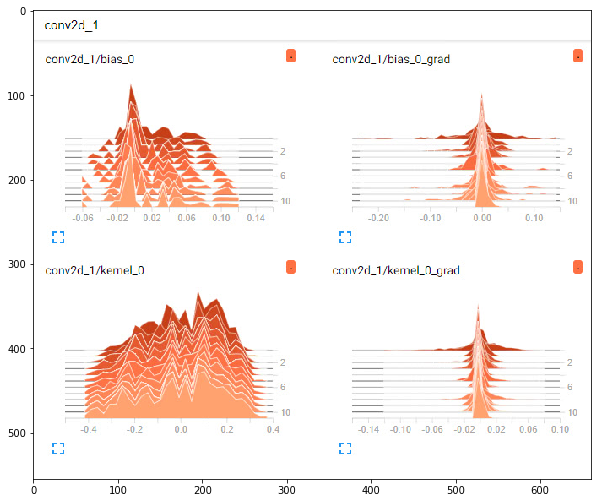

In [56]:
import urllib

url ='https://gitcdn.xyz/cdn/Tony607/blog_statics/d425c3fe4cf0d92067572e25ae6cc3198d51936b//images/ngrok/histograms_conv2d_1.png'
req = urllib.request.urlopen(url)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.cvtColor(cv2.imdecode(arr, -1), cv2.COLOR_RGB2BGR) # 'Load it as it is'

_, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(img)
plt.show()